# Issue Addressor Agent

This agent is responsible for addressing issues on the codebase. A title and description are extracted from the Gitlab or Github issue and passed to the agent.

It will start by distinguishing if the details are requests to change the code and if so, it will plan and execute the next steps.

In [66]:
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.store.memory import InMemoryStore
from langgraph.types import Command
from rich import print  # noqa: A004

from automation.agents.issue_addressor import IssueAddressorAgent
from automation.conf import settings
from automation.utils import file_changes_namespace

source_repo_id = "dipcode/django-webhooks"
source_ref = "master"

config = {
    "run_name": "IssueAddressor",
    "recursion_limit": settings.RECURSION_LIMIT,
    "configurable": {"source_repo_id": source_repo_id, "source_ref": source_ref, "thread_id": "1"},
}
store = InMemoryStore()
checkpointer = InMemorySaver()
issue_addressor = IssueAddressorAgent(store=store, checkpointer=checkpointer)

## Graph 

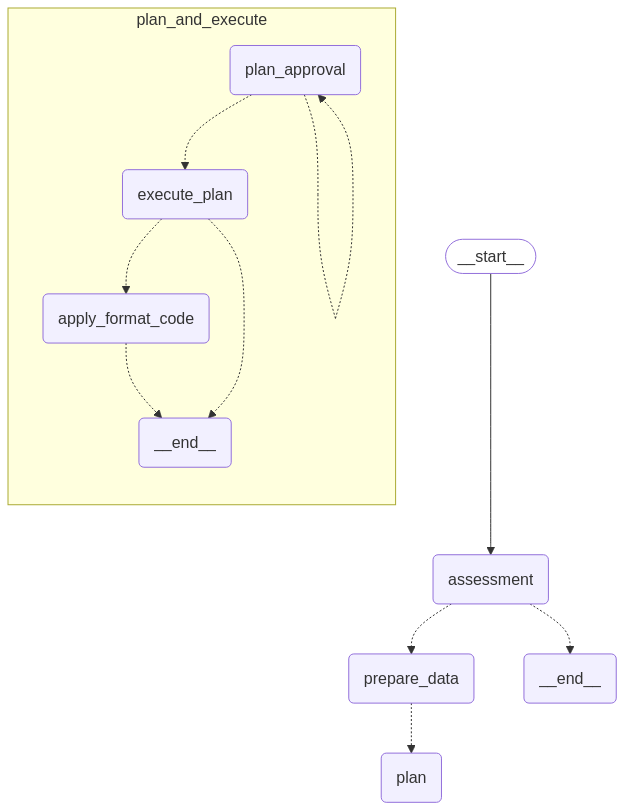

In [71]:
from IPython.display import Image, display  # noqa: A004

display(Image(issue_addressor.draw_mermaid()))

---

## Examples

Here are examples of the issue addressor agent in action. 

### Issue with no code changes

Before the agent is run, the issue is assessed to check if it is a request for code changes.

If it is not, the agent will not plan or execute any changes.

In [38]:
result = issue_addressor.agent.invoke(
    {"issue_title": "Review README.md", "issue_description": "Is the README.md file up to date?"},
    config=config,
    subgraphs=True,
)

In [39]:
print(result[1]["request_for_changes"])

False

### Issue with code changes

When the issue is a request for code changes, the agent will plan the changes to be made and wait for approval before executing them.

In [62]:
result = issue_addressor.agent.invoke(
    {
        "issue_title": "Coverage improvement",
        "issue_description": "Add unittests to cover the file `webhooks/contrib/rest_framework/serializers.py`",
    },
    config=config,
    subgraphs=True,
)

In [63]:
print(result[1]["plan_goal"])
print(result[1]["plan_tasks"])

Add unit tests to improve coverage for the file webhooks/contrib/rest_framework/serializers.py

[
    Task(
        title='Create a test file for the REST framework serializers',
        description="Create a new test file specifically for testing the serializers in the REST framework contrib 
module. This follows the project's pattern of having dedicated test files for each component.",
        subtasks=[
            'Create a new file named `test_rest_framework_serializers.py` in the `webhooks/tests/` directory.',
            "Add necessary imports including `unittest.mock`, Django's `TestCase`, and REST framework's testing 
utilities.",
            'Import the necessary components from the project: `BaseCallbackSerializer`, `WebhookModelOperation`, 
constants, and `generate_signature_token`.'
        ],
        path='webhooks/tests/test_rest_framework_serializers.py',
        context_paths=[
            'webhooks/contrib/rest_framework/serializers.py',
            'webhooks/tests/test_utils.py',
            'webhooks/tests/utils.py'
        ]
    ),
    Task(
        title='Create a test class for BaseCallbackSerializer',
        description='Implement a test class that will test various aspects of the `BaseCallbackSerializer` 
implementation. We need to test validation logic, error handling, and the abstract methods.',
        subtasks=[
            "Create a `TestBaseCallbackSerializer` class that inherits from Django's `TestCase`.",
            'Create a test implementation of `BaseCallbackSerializer` that defines the required `WEBHOOK_SECRET` 
and implements the abstract methods.',
            'Set up test fixtures in `setUp` method including mock requests and headers.'
        ],
        path='webhooks/tests/test_rest_framework_serializers.py',
        context_paths=['webhooks/contrib/rest_framework/serializers.py', 'webhooks/tests/test_utils.py']
    ),
    Task(
        title='Test successful validation in BaseCallbackSerializer',
        description='Test the case where the serializer validation succeeds because all required headers are 
present and the signature is valid.',
        subtasks=[
            'Create a test method `test_validate_success`.',
            'Set up mock request with all required headers.',
            'Generate a valid signature using the `generate_signature_token` function.',
            'Initialize the serializer with valid data and context.',
            'Call validate method and assert it returns the expected attributes without raising exceptions.',
            'Assert that the returned attributes include the operation value.'
        ],
        path='webhooks/tests/test_rest_framework_serializers.py',
        context_paths=[
            'webhooks/contrib/rest_framework/serializers.py',
            'webhooks/utils.py',
            'webhooks/tests/test_utils.py'
        ]
    ),
    Task(
        title='Test missing headers validation',
        description='Test the case where validation fails because one or more required headers are missing.',
        subtasks=[
            'Create a test method `test_validate_missing_headers`.',
            'Create test cases for each missing header (event, event_uuid, event_timestamp, event_signature).',
            'For each test case, set up a context with the header missing.',
            'Assert that ValidationError is raised with the appropriate message.',
            'Test the case where multiple headers are missing.'
        ],
        path='webhooks/tests/test_rest_framework_serializers.py',
        context_paths=['webhooks/contrib/rest_framework/serializers.py', 'webhooks/constants.py']
    ),
    Task(
        title='Test invalid signature validation',
        description='Test the case where validation fails because the provided signature does not match the 
expected one.',
        subtasks=[
            'Create a test method `test_validate_invalid_signature`.',
            'Set up mock request with all required headers but with an invalid signature.',
            'Initialize the serializer with valid data and context.',
            'A

Now that i have my plan defined, i need to approve it in order to execute it. The approval must be explicit, otherwise the agent will not execute the plan.

Here an example of a plan that is not explicitly approved:

In [64]:
result = issue_addressor.agent.invoke(Command(resume=[("human", "I like the plan.")]), config=config, subgraphs=True)
print(result[1]["plan_approval_response"])

Now, an example of a plan that is explicitly approved:

In [ ]:
result = issue_addressor.agent.invoke(Command(resume=[("human", "I approve the plan")]), config=config, subgraphs=True)

In [ ]:
print(result[1]["plan_approval_response"])

In [65]:
for item in store.search(file_changes_namespace(source_repo_id, source_ref)):
    print(f"============================= {item.key} =============================")
    print(item.value["data"].content)

============================= webhooks/tests/test_rest_framework_serializers.py =============================

from unittest import mock

from django.test import TestCase

from rest_framework.test import APIRequestFactory

from webhooks.choices import WebhookModelOperation
from webhooks.constants import (
    WEBHOOK_HEADER_EVENT,
    WEBHOOK_HEADER_EVENT_SIGNATURE,
    WEBHOOK_HEADER_EVENT_TIMESTAMP,
    WEBHOOK_HEADER_EVENT_UUID,
)
from webhooks.contrib.rest_framework.serializers import BaseCallbackSerializer
from webhooks.utils import generate_signature_token


class TestCallbackSerializer(BaseCallbackSerializer):
    """Concrete implementation of BaseCallbackSerializer for testing."""

    WEBHOOK_SECRET = "test_secret"  # noqa: S105

    def accept_callback(self):
        return True

    def process_callback(self):
        return {"processed": True}


class TestBaseCallbackSerializer(TestCase):
    def setUp(self):
        self.factory = APIRequestFactory()
        self.test_data = {"operation": WebhookModelOperation.CREATE}
        self.event = "test_event"
        self.event_uuid = "test_uuid_12345"
        self.event_timestamp = "1672531200"  # 2023-01-01 00:00:00 UTC

        # Generate a valid signature for testing
        self.valid_signature = generate_signature_token(
            self.event_uuid, self.event_timestamp, self.event, TestCallbackSerializer.WEBHOOK_SECRET
        )

        # Create a request with valid headers
        self.request = self.factory.post("/callbacks/")
        self.request.headers = {
            WEBHOOK_HEADER_EVENT: self.event,
            WEBHOOK_HEADER_EVENT_UUID: self.event_uuid,
            WEBHOOK_HEADER_EVENT_TIMESTAMP: self.event_timestamp,
            WEBHOOK_HEADER_EVENT_SIGNATURE: self.valid_signature,
        }

    def test_validate_success(self):
        """Test successful validation with all required headers and valid signature."""
        serializer = TestCallbackSerializer(data=self.test_data, context={"request": self.request})

        # The serializer should be valid
        self.assertTrue(serializer.is_valid())

        # The validated data should contain the operation
        self.assertEqual(serializer.validated_data["operation"], WebhookModelOperation.CREATE)

        # The concrete implementation should work as expected
        self.assertTrue(serializer.accept_callback())
        self.assertEqual(serializer.process_callback(), {"processed": True})

    def test_validate_missing_headers(self):
        """Test validation failure when required headers are missing."""
        # Test each missing header individually
        required_headers = [
            WEBHOOK_HEADER_EVENT,
            WEBHOOK_HEADER_EVENT_UUID,
            WEBHOOK_HEADER_EVENT_TIMESTAMP,
            WEBHOOK_HEADER_EVENT_SIGNATURE,
        ]

        for header in required_headers:
            # Create a request with the current header missing
            request = self.factory.post("/callbacks/")
            headers = dict(self.request.headers)
            headers.pop(header)
            request.headers = headers

            serializer = TestCallbackSerializer(data=self.test_data, context={"request": request})

            # The serializer should not be valid
            self.assertFalse(serializer.is_valid())

            # There should be a validation error with the expected message
            self.assertIn("Missing required headers for the webhook event callback.", str(serializer.errors))

        # Test with multiple headers missing
        request = self.factory.post("/callbacks/")
        request.headers = {}  # No headers at all

        serializer = TestCallbackSerializer(data=self.test_data, context={"request": request})

        # The serializer should not be valid
        self.assertFalse(serializer.is_valid())

        # There should be a validation error with the expected message
        self.assertIn("Missing required headers for the webhook event callback.", str(serializer.errors))

    def test_validate_invalid_signature(self):
        """Test validation failure when the signature is i

============================= CHANGELOG.md =============================

# Changelog

All notable changes to this project will be documented in this file.

The format is based on [Keep a Changelog](http://keepachangelog.com/en/1.0.0/)
and this project adheres to [Semantic Versioning](http://semver.org/spec/v2.0.0.html).

## [Unreleased]

### Added

- Added unit tests for REST framework serializers.

## [0.3.2] - 2024-08-13

### Fixed

- Another tentative to resolve response not being defined at some circumstances.

## [0.3.1] - 2024-08-13

### Removed

- Removed `authentication_classes` and `permission_classes` from `BaseCallbackView` to allow the user to set it on 
the view.

### Fixed

- Removed `MovementCallbackSerializer` and `WEBHOOK_EVENT_PAYMENTS_MOVEMENT` from `BaseCallbackView`;
- Fixed bug on `send_webhook_request` where `response` could not be defined at some circumstances.

## [0.3.0] - 2024-08-12

### Added

- Added `rest_framework` integration with base view and serializer to help handle callbacks.

### Changed

- Changed `__str__` of models to return more readable information.

### Fixed

- Fixed reponse not being stored on `WebhookEvent` model.

## [0.2.4] - 2024-08-10

### Fixed

- Fixed signals being considered as weak and being garbage collected 
(https://docs.djangoproject.com/en/dev/topics/signals/#:~:text=weak%20%E2%80%93%20Django%20stores%20signal%20handle
rs,the%20signal's%20connect()%20method.)

## [0.2.3] - 2024-08-10

### Fixed

- Fixed signals not being connected.

## [0.2.2] - 2024-08-09

### Added

- Added logging to webhook registry.

### Changed

- Changed all logger to use the same name.

## [0.2.1] - 2024-08-09

### Fixed

- Model dump on payload was generating non-serializable data.

## [0.2.0] - 2024-08-08

### Added

- Webhook event name is sent on the payload of the request too.
- Added constants with header names.

### Changed

- Changed method `generate_signature_token` to generate the signature of the webhook event. The payload was removed
and the event uuid was added to the signature. **BREACKING CHANGE**.
- Admin webhooks list now shows as a `filter_horizontal` on `WebhookSubscriptionAdmin`.

### Fixed

- Payload was being saved in the database as a string, now it is saved as a JSON object.

## [0.1.1] - 2024-07-19

### Fixed

- Serialize payload correctly in post request.

## [0.1.0] - 2024-07-12

### Added

- First commit

[Unreleased]: https://git.eurotux.com/dipcode/python/django-webhooks/-/compare/v0.3.2...master
[0.3.2]: https://git.eurotux.com/dipcode/python/django-webhooks/-/compare/v0.3.1...v0.3.2
[0.3.1]: https://git.eurotux.com/dipcode/python/django-webhooks/-/compare/v0.3.0...v0.3.1
[0.3.0]: https://git.eurotux.com/dipcode/python/django-webhooks/-/compare/v0.2.4...v0.3.0
[0.2.4]: https://git.eurotux.com/dipcode/python/django-webhooks/-/compare/v0.2.3...v0.2.4
[0.2.3]: https://git.eurotux.com/dipcode/python/django-webhooks/-/compare/v0.2.2...v0.2.3
[0.2.2]: https://git.eurotux.com/dipcode/python/django-webhooks/-/compare/v0.2.1...v0.2.2
[0.2.1]: https://git.eurotux.com/dipcode/python/django-webhooks/-/compare/v0.2.0...v0.2.1
[0.2.0]: https://git.eurotux.com/dipcode/python/django-webhooks/-/compare/v0.1.1...v0.2.0
[0.1.1]: https://git.eurotux.com/dipcode/python/django-webhooks/-/compare/v0.1.0...v0.1.1
[0.1.0]: https://git.eurotux.com/dipcode/python/django-webhooks/tree/0.1.0

### Issue with concrete code changes

There are cases where the issue description includes concrete code changes, like a code snippet, a code block, a list of choices, etc... and we need to ensure the agent will include the necessary context in the plan to perform the changes.

Let's see an example:

In [67]:
result = issue_addressor.agent.invoke(
    {
        "issue_title": "New choices for model operations",
        "issue_description": """Add new choices for model operations:
* list - with translation "List"
* get - with translation "Get"
* search - with translation "Search"
* filter - with translation "Filter"
* bulk_create - with translation "Bulk create"
* bulk_update - with translation "Bulk update"
* bulk_delete - with translation "Bulk delete"
""",
    },
    config=config,
    subgraphs=True,
)

In [ ]:
print(result[1]["plan_goal"])
print(result[1]["plan_tasks"])

In [68]:
result = issue_addressor.agent.invoke(Command(resume=[("human", "I approve the plan")]), config=config, subgraphs=True)

In [69]:
for item in store.search(file_changes_namespace(source_repo_id, source_ref)):
    print(f"============================= {item.key} =============================")
    print(item.value["data"].content)

============================= webhooks/choices.py =============================

from django.db.models import TextChoices
from django.utils.translation import gettext_lazy as _


class WebhookModelOperation(TextChoices):
    CREATE = "create", _("Create")
    UPDATE = "update", _("Update")
    DELETE = "delete", _("Delete")
    LIST = "list", _("List")
    GET = "get", _("Get")
    SEARCH = "search", _("Search")
    FILTER = "filter", _("Filter")
    BULK_CREATE = "bulk_create", _("Bulk create")
    BULK_UPDATE = "bulk_update", _("Bulk update")
    BULK_DELETE = "bulk_delete", _("Bulk delete")

============================= CHANGELOG.md =============================

# Changelog

All notable changes to this project will be documented in this file.

The format is based on [Keep a Changelog](http://keepachangelog.com/en/1.0.0/)
and this project adheres to [Semantic Versioning](http://semver.org/spec/v2.0.0.html).

## [Unreleased]

### Added

- Added new choices for model operations: list, get, search, filter, bulk_create, bulk_update, and bulk_delete.

## [0.3.2] - 2024-08-13

### Fixed

- Another tentative to resolve response not being defined at some circumstances.

## [0.3.1] - 2024-08-13

### Removed

- Removed `authentication_classes` and `permission_classes` from `BaseCallbackView` to allow the user to set it on 
the view.

### Fixed

- Removed `MovementCallbackSerializer` and `WEBHOOK_EVENT_PAYMENTS_MOVEMENT` from `BaseCallbackView`;
- Fixed bug on `send_webhook_request` where `response` could not be defined at some circumstances.

## [0.3.0] - 2024-08-12

### Added

- Added `rest_framework` integration with base view and serializer to help handle callbacks.

### Changed

- Changed `__str__` of models to return more readable information.

### Fixed

- Fixed reponse not being stored on `WebhookEvent` model.

## [0.2.4] - 2024-08-10

### Fixed

- Fixed signals being considered as weak and being garbage collected 
(https://docs.djangoproject.com/en/dev/topics/signals/#:~:text=weak%20%E2%80%93%20Django%20stores%20signal%20handle
rs,the%20signal's%20connect()%20method.)

## [0.2.3] - 2024-08-10

### Fixed

- Fixed signals not being connected.

## [0.2.2] - 2024-08-09

### Added

- Added logging to webhook registry.

### Changed

- Changed all logger to use the same name.

## [0.2.1] - 2024-08-09

### Fixed

- Model dump on payload was generating non-serializable data.

## [0.2.0] - 2024-08-08

### Added

- Webhook event name is sent on the payload of the request too.
- Added constants with header names.

### Changed

- Changed method `generate_signature_token` to generate the signature of the webhook event. The payload was removed
and the event uuid was added to the signature. **BREACKING CHANGE**.
- Admin webhooks list now shows as a `filter_horizontal` on `WebhookSubscriptionAdmin`.

### Fixed

- Payload was being saved in the database as a string, now it is saved as a JSON object.

## [0.1.1] - 2024-07-19

### Fixed

- Serialize payload correctly in post request.

## [0.1.0] - 2024-07-12

### Added

- First commit

[Unreleased]: https://git.eurotux.com/dipcode/python/django-webhooks/-/compare/v0.3.2...master
[0.3.2]: https://git.eurotux.com/dipcode/python/django-webhooks/-/compare/v0.3.1...v0.3.2
[0.3.1]: https://git.eurotux.com/dipcode/python/django-webhooks/-/compare/v0.3.0...v0.3.1
[0.3.0]: https://git.eurotux.com/dipcode/python/django-webhooks/-/compare/v0.2.4...v0.3.0
[0.2.4]: https://git.eurotux.com/dipcode/python/django-webhooks/-/compare/v0.2.3...v0.2.4
[0.2.3]: https://git.eurotux.com/dipcode/python/django-webhooks/-/compare/v0.2.2...v0.2.3
[0.2.2]: https://git.eurotux.com/dipcode/python/django-webhooks/-/compare/v0.2.1...v0.2.2
[0.2.1]: https://git.eurotux.com/dipcode/python/django-webhooks/-/compare/v0.2.0...v0.2.1
[0.2.0]: https://git.eurotux.com/dipcode/python/django-webhooks/-/compare/v0.1.1...v0.2.0
[0.1.1]: https://git.eurotux.com/dipcode/python/django-webhooks/-/compare/v0.1.0...v0.1.1
[0.1.0]: https://git.eurotux.com/dipcode/python/django-webhooks/tree/0.1.0